In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

r_seed = 31415
np.random.seed(r_seed)
tf.set_random_seed(r_seed)

In [2]:
def model_variable(shape, name, initializer=tf.random_normal_initializer(stddev=1)):
        variable = tf.get_variable(name=name,
                                   dtype=tf.float32,
                                   shape=shape,
                                   initializer=initializer
        )
        tf.add_to_collection('model_variables', variable)
        tf.add_to_collection('l2', tf.reduce_sum(tf.pow(variable,2)))
        return variable
    
class Model():
    def __init__(self, sess, data, nEpochs, learning_rate, n_input=2, n_output=2):
        self.sess = sess
        self.data = data()
        self.nEpochs = nEpochs
        self.learning_rate = learning_rate
        self.n_input = n_input
        self.n_layer1 = 30
        self.n_layer2 = 15
        self.n_output = n_output
        
        self.build_model()
        
    def build_model(self):
        
        self.x = tf.placeholder(tf.float32, shape=[1,2])
        self.y = tf.placeholder(tf.float32, shape=[1,2])
        
        self.h1w = model_variable([self.n_input, self.n_layer1], 'h1w')
        self.h2w = model_variable([self.n_layer1, self.n_layer2], 'h2w')
        self.outputw = model_variable([self.n_layer2, self.n_output], 'outputw')
        
        self.h1b = model_variable([self.n_layer1], 'h1b')
        self.h2b = model_variable([self.n_layer2], 'h2b')
        self.outputb = model_variable([self.n_output], 'outputb')
        
        layer_1 = tf.nn.relu(
                    tf.add(
                        tf.matmul(self.x, self.h1w),
                        self.h1b)
                    )
        layer_2 = tf.nn.relu(
                    tf.add(
                        tf.matmul(layer_1, self.h2w),
                        self.h2b)
                    )
        
        self.layer_out = tf.add(
                        tf.matmul(layer_2, self.outputw),
                        self.outputb)

        self.output = tf.nn.softmax(self.layer_out)
        
        self.yhat = self.output
        
    def train_init(self):
        model_variables = tf.get_collection('model_variables')
        wts = tf.trainable_variables()
        logloss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=self.layer_out,
                labels=self.y
            )
        )
        l2_penalty = tf.add_n(
            [ tf.nn.l2_loss(wt) for wt in wts if 'b' not in wt.name ]
        ) * 1e-3
        cost = logloss + l2_penalty
        self.optim = (
            tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            .minimize(cost, var_list=model_variables)
            )
        self.sess.run(tf.global_variables_initializer())

    def train_iter(self, x, y):
        y_list = np.reshape([1.0-y, y], (1,2))
        self.sess.run(self.optim,
                      feed_dict={self.x : x, self.y : y_list})

    def train(self):
        for _ in range(self.nEpochs):
            for x, y in self.data:
                x = x.reshape((1,2))
                self.train_iter(x, y)

    def infer(self, x):
        return self.sess.run(self.yhat, feed_dict={self.x : x})


In [3]:
# generate data

def noise() :
    sigma = 0.1
    return sigma * np.array([np.random.normal(), np.random.normal()])

def data(num_samp=5000):
    magnitude = 1;
    sigma = 0.1
    for _ in range(num_samp):
        y = 1 if np.random.uniform(0, 1) > 0.5 else 0
        shift = np.pi if y else 0
        t = np.random.uniform(0, 3* np.pi)
        x = magnitude * t * np.array([np.sin(t + shift), np.cos(t + shift)]) + noise()
        yield x, y

gen_data = zip(*list(data()))

examples, targets = gen_data
examples = np.array(examples)


In [4]:
# model init

sess = tf.Session()
model = Model(sess, data, nEpochs=50, learning_rate=1e-2)

In [5]:
# train model

model.train_init()
model.train()

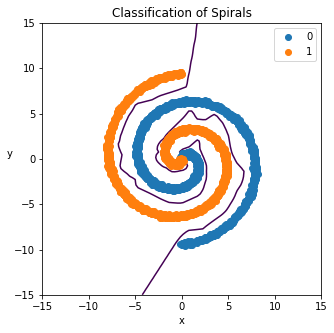

In [6]:
# evaluate and plot results

t = np.linspace(-15, 15, 100)

tplt = []
lplt = []

xv, yv = np.meshgrid(t, t)

xvf = xv.flatten()
yvf = yv.flatten()

for xplt, yplt in zip(xvf, yvf):
    pred = model.infer(np.array([xplt, yplt]).reshape((1,2)))[0][1]
    tplt.append(pred)
    lplt.append(pred > 0.5)
tplt = np.array(tplt).reshape(xv.shape)
    
df = pd.DataFrame(dict(x=examples[:,0], y=examples[:, 1], label=targets))

groups = df.groupby('label')

fig, ax = plt.subplots(1,1)

fig.set_size_inches(5,5)

for name, group in groups:
    plt.plot(group.x, group.y, marker='.', linestyle='', ms=12, label=name)
plt.legend()

plt.contour(xv, yv, tplt, levels=[0.5])

plt.xlabel('x')
plt.ylabel('y').set_rotation(0)
plt.title('Classification of Spirals')
plt.show()